In [1]:
! pip install tensorflow_history_plot

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import PIL.ImageOps
from tensorflow_history_plot import show_acc

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

## Load Dataset

In [4]:
(ds_train, ds_test), ds_info = tfds.load('mnist', split=['train', 'test'], with_info=True, as_supervised=True)

## Show Dataset Info 

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

## Show a sample Data

size:(28, 28, 1),max:255,min:0
label:4


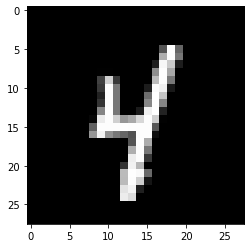

In [6]:
for element in ds_train.as_numpy_iterator():
    sample_data, sample_label = element
    break

print("size:{},max:{},min:{}".format(sample_data.shape,
                                     np.max(sample_data),
                                     np.min(sample_data)))
print("label:{}".format(sample_label))
plt.imshow(sample_data.squeeze(), interpolation='nearest', cmap="gray")
plt.show()

In [7]:
IMG_HEIGHT = 28
IMG_WIDTH = 28

## Normalize
因为数据集的值的范围是0～255，所以需要归一化一下。

In [8]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

size:(28, 28, 1),max:1.0,min:0.0


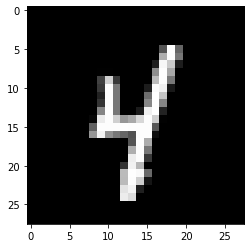

In [9]:
nor_sample_data, _ = normalize_img(sample_data, sample_label)
print("size:{},max:{},min:{}".format(nor_sample_data.shape,
                                     np.max(nor_sample_data),
                                     np.min(nor_sample_data)))
plt.imshow(tf.squeeze(nor_sample_data), interpolation='nearest', cmap="gray")
plt.show()

## Build Input Pipeline

In [10]:
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .cache() \
    .shuffle(ds_info.splits['train'].num_examples) \
    .batch(128) \
    .prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .batch(128) \
    .cache() \
    .prefetch(tf.data.experimental.AUTOTUNE)

## Build Model

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

## Compile Model

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## Train

In [14]:
history = model.fit(
    ds_train,
    epochs=60,
    validation_data=ds_test
)

Epoch 1/60
469/469 [==============================] - 11s 7ms/step - loss: 0.6446 - accuracy: 0.8183 - val_loss: 0.1908 - val_accuracy: 0.9456
Epoch 2/60
469/469 [==============================] - 1s 3ms/step - loss: 0.1768 - accuracy: 0.9505 - val_loss: 0.1351 - val_accuracy: 0.9604
Epoch 3/60
469/469 [==============================] - 1s 3ms/step - loss: 0.1239 - accuracy: 0.9654 - val_loss: 0.1098 - val_accuracy: 0.9659
Epoch 4/60
469/469 [==============================] - 1s 3ms/step - loss: 0.0909 - accuracy: 0.9740 - val_loss: 0.0949 - val_accuracy: 0.9730
Epoch 5/60
469/469 [==============================] - 2s 3ms/step - loss: 0.0739 - accuracy: 0.9802 - val_loss: 0.0860 - val_accuracy: 0.9745
Epoch 6/60
469/469 [==============================] - 1s 3ms/step - loss: 0.0603 - accuracy: 0.9834 - val_loss: 0.0821 - val_accuracy: 0.9754
Epoch 7/60
469/469 [==============================] - 2s 3ms/step - loss: 0.0486 - accuracy: 0.9865 - val_loss: 0.0781 - val_accuracy: 0.9768
Epoch

## Visualize Training Result

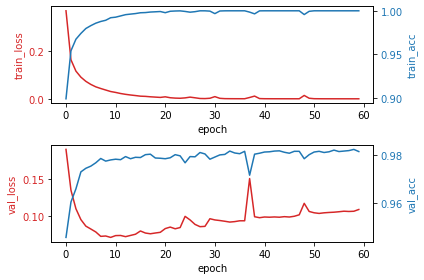

In [15]:
show_acc.plot(history)

其实可以看出，10个epoch后就开始过拟合了。

## 添加Dropout层
减少过拟合

In [16]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])

model2.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

history2 = model2.fit(
    ds_train,
    epochs=60,
    validation_data=ds_test,
)

Epoch 1/60
469/469 [==============================] - 2s 4ms/step - loss: 0.7432 - accuracy: 0.7767 - val_loss: 0.2031 - val_accuracy: 0.9403
Epoch 2/60
469/469 [==============================] - 2s 3ms/step - loss: 0.2525 - accuracy: 0.9256 - val_loss: 0.1439 - val_accuracy: 0.9570
Epoch 3/60
469/469 [==============================] - 2s 3ms/step - loss: 0.1878 - accuracy: 0.9438 - val_loss: 0.1147 - val_accuracy: 0.9656
Epoch 4/60
469/469 [==============================] - 2s 3ms/step - loss: 0.1600 - accuracy: 0.9514 - val_loss: 0.1031 - val_accuracy: 0.9685
Epoch 5/60
469/469 [==============================] - 2s 3ms/step - loss: 0.1350 - accuracy: 0.9599 - val_loss: 0.0883 - val_accuracy: 0.9734
Epoch 6/60
469/469 [==============================] - 2s 3ms/step - loss: 0.1238 - accuracy: 0.9617 - val_loss: 0.0848 - val_accuracy: 0.9737
Epoch 7/60
469/469 [==============================] - 2s 3ms/step - loss: 0.1112 - accuracy: 0.9662 - val_loss: 0.0797 - val_accuracy: 0.9745
Epoch 

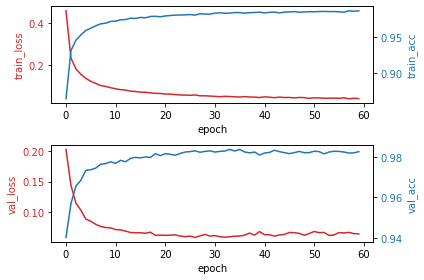

In [17]:
show_acc.plot(history2)

## 拿张图片试试
我们从网上找一个数据集之外的图片看看

40960/34172 [===================================] - 0s 1us/step


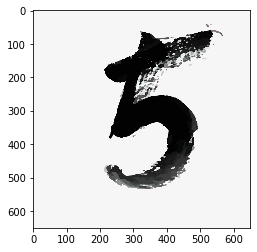

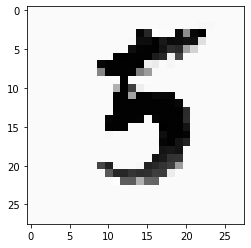

In [18]:
sunflower_url = "https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fbpic.588ku.com%2Felement_origin_min_pic%2F18%2F06%2F09%2F45fb84189924b2e6695f494ab9e2df89.jpg&refer=http%3A%2F%2Fbpic.588ku.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1615431034&t=3c1aaed9443c89ef8594d689eac0e5bc"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img_origin = tf.keras.preprocessing.image.load_img(sunflower_path)
plt.imshow(img_origin, interpolation='nearest')
plt.show()

img = tf.keras.preprocessing.image.load_img(
    sunflower_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale"
)
plt.imshow(img, interpolation='nearest', cmap="gray")
plt.show()

需要注意的是，这里的格式和我们的训练集是完全相反的，训练集的数字主体是非0值（白色），背景是0（黑色）。虽然我们人一眼就能看出这是5（因为黑色白色对我们没影响，我们是根据空间结构判断的），但是对于机器来说这个input的特征和训练时遇到的5基本没啥相似点，很大可能会识别为别的数字（我试了，它认为这个是铁7）。所以我们需要对这个图片预处理一下，让其符合我们模型的输入分布。

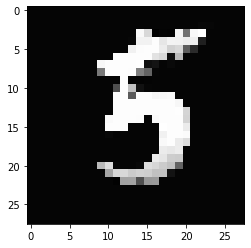

In [19]:
img_fixed = PIL.ImageOps.invert(img)
plt.imshow(img_fixed, interpolation='nearest', cmap="gray")
plt.show()

是骡子是马，拉出来溜溜！

In [20]:
img_array = tf.keras.preprocessing.image.img_to_array(img_fixed)
img_array = tf.expand_dims(img_array, 0)
predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])
class_names = list(range(10))
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 5 with a 100.00 percent confidence.


✌️